In [1]:
import matplotlib.pyplot as plt
import pandas as pd

import time
import numpy as np
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch

In [2]:
np.eye(10)[[0, 1, 2, 3, 4, 5, 6, 7, 8]]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])

### parameters

In [3]:
RANDOM_SEED = 1
BATCH_SIZE = 100
NUM_EPOCHS = 10

### data

In [4]:
train_dataset = datasets.MNIST(root='D:/work/data/Python/mnist/', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='D:/work/data/Python/mnist/', 
                              train=False, 
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([100, 1, 28, 28])
Image label dimensions: torch.Size([100])


### model

In [5]:
class MultilayerPerceptron():

    def __init__(self, num_features, num_hidden, num_classes):
        super(MultilayerPerceptron, self).__init__()
        
        self.num_classes = num_classes
        self.num_hidden = num_hidden
        self.num_features = num_features
        
        # hidden 1
        self.weight_1 = torch.zeros(num_hidden, num_features, 
                                    dtype=torch.float).normal_(0.0, 0.1)
        self.bias_1 = torch.zeros(num_hidden, dtype=torch.float)
        
        # output
        self.weight_o = torch.zeros(self.num_classes, num_hidden, 
                                    dtype=torch.float).normal_(0.0, 0.1)
        self.bias_o = torch.zeros(self.num_classes, dtype=torch.float)
        
    def forward(self, x):
        # hidden 1
        
        # input dim: [n_hidden, n_features] dot [n_features, n_examples] .T
        # output dim: [n_examples, n_hidden]
        z_1 = torch.mm(x, self.weight_1.t()) + self.bias_1
        a_1 = torch.sigmoid(z_1)

        # hidden 2
        # input dim: [n_classes, n_hidden] dot [n_hidden, n_examples] .T
        # output dim: [n_examples, n_classes]
        z_2 = torch.mm(a_1, self.weight_o.t()) + self.bias_o
        a_2 = torch.sigmoid(z_2)
        return a_1, a_2

    def backward(self, x, a_1, a_2, y):
        '''
            sigmoid'(Z2)表示simoid函数对Z2求导, a2 = sigmoid(Z2), sigmoid'(Z2) = a2*(1 - a2)
            
            dZ2 = (a2 - y) @ sigmoid'(Z2)
            dW2 = a1 @ dZ2
            db1 = dZ2
            
            dZ1 = W2 @ dZ2 @ sigmoid'(Z1)
            dW1 = X @ dZ1
            db1 = dZ1
        '''
        y_onehot = torch.zeros(y.size(0), self.num_classes).scatter_(1, y.view(-1,1).long(), 1)
        
        '''
            a2: [n_examples, n_classes]
            dZ2: [n_examples, n_classes]
            dw2: [num_classes, num_hidden]
            db2: [num_classes]
            
            a1: [n_examples, num_hidden]
            dZ1: [n_examples, num_hidden]
            dW1: [num_hidden, num_features]
            db1: [num_hidden]
        '''
#         print(x.size())
#         print(a_1.size())
#         print(a_2.size())
#         print(y.size())
#         print(y_onehot.size())
        
        # sigmoid derivative: da2 / dZ2
        da2_dZ2 = a_2 * (1 - a_2)
        # Z2 derivative: dLoss / dZ2
        # dZ2: [n_examples, n_classes]
        dZ2 = (a_2 - y_onehot) * da2_dZ2
        # W2 derivative: dLoss / dW2
        # dW2: [num_classes, num_hidden]
        dW2 = torch.mm(dZ2.t(), a_1)
        db2 = torch.sum(dZ2, dim=0)
        assert(dW2.size(0) == self.num_classes)
        assert(dW2.size(1) == self.num_hidden)
        
        da1_dZ1 = a_1 * (1 - a_1)
        # dZ1: [n_examples, num_hidden]
        dZ1 = torch.mm(dZ2, self.weight_o) * da1_dZ1
        # dW1: [num_hidden, num_features]
        dW1 = torch.mm(dZ1.t(), x)
        db1 = torch.sum(dZ1, dim=0)
        assert(dW1.size(0) == self.num_hidden)
        assert(dW1.size(1) == self.num_features)
        return dW2, db2, dW1, db1

### train

In [6]:
def to_onehot(y, num_classes):
    y_onehot = torch.zeros(y.size(0), self.num_classes).scatter_(1, y.view(-1,1).long(), 1)
    return y_onehot


def loss_func(targets_onehot, probas_onehot):
    return torch.mean(torch.mean((targets_onehot - probas_onehot)**2, dim=0))


def compute_mse(net, data_loader):
    curr_mse, num_examples = torch.zeros(model.num_classes).float(), 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.view(-1, 28*28)
            logits, probas = net.forward(features)
            y_onehot = to_onehot(targets, model.num_classes)
            loss = torch.sum((y_onehot - probas)**2, dim=0)
            num_examples += targets.size(0)
            curr_mse += loss

        curr_mse = torch.mean(curr_mse/num_examples, dim=0)
        return curr_mse


def train(model, data_loader, num_epochs,
          learning_rate=0.1):
    
    minibatch_cost = []
    epoch_cost = []
    
    for e in range(num_epochs):
        
        for batch_idx, (features, targets) in enumerate(train_loader):
            
            features = features.view(-1, 28*28)
            
            #### Compute outputs ####
            a_1, a_2 = model.forward(features)

            #### Compute gradients ####
            dloss__dw_out, dloss__db_out, dloss_dw1, dloss_db1 = \
                model.backward(features, a_1, a_2, targets)

            #### Update weights ####
            model.weight_1 -= learning_rate * dloss_dw1
            model.bias_1 -= learning_rate * dloss_db1
            model.weight_o -= learning_rate * dloss__dw_out
            model.bias_o -= learning_rate * dloss__db_out
            
            #### Logging ####
            curr_cost = loss_func(to_onehot(targets, model.num_classes), a_2)
            minibatch_cost.append(curr_cost)
            if not batch_idx % 50:
                print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                       %(e+1, NUM_EPOCHS, batch_idx, 
                         len(train_loader), curr_cost))
        
        #### Logging ####        
        curr_cost = compute_mse(model, train_loader)
        epoch_cost.append(curr_cost)
        print('Epoch: %03d/%03d |' % (e+1, NUM_EPOCHS), end="")
        print(' Train MSE: %.5f' % curr_cost)

    return minibatch_cost, epoch_cost

In [7]:
torch.manual_seed(RANDOM_SEED)
model = MultilayerPerceptron(num_features=28*28,
                             num_hidden=50,
                             num_classes=10)

minibatch_cost, epoch_cost = train(model, 
                                   train_loader,
                                   num_epochs=NUM_EPOCHS,
                                   learning_rate=0.1)

Epoch: 001/010 | Batch 000/600 | Cost: 0.2471
Epoch: 001/010 | Batch 050/600 | Cost: 0.1000
Epoch: 001/010 | Batch 100/600 | Cost: 0.1000
Epoch: 001/010 | Batch 150/600 | Cost: 0.0999
Epoch: 001/010 | Batch 200/600 | Cost: 0.0995
Epoch: 001/010 | Batch 250/600 | Cost: 0.0999
Epoch: 001/010 | Batch 300/600 | Cost: 0.0955
Epoch: 001/010 | Batch 350/600 | Cost: 0.0906
Epoch: 001/010 | Batch 400/600 | Cost: 0.0921
Epoch: 001/010 | Batch 450/600 | Cost: 0.0912
Epoch: 001/010 | Batch 500/600 | Cost: 0.0859
Epoch: 001/010 | Batch 550/600 | Cost: 0.0810
Epoch: 001/010 | Train MSE: 0.08387
Epoch: 002/010 | Batch 000/600 | Cost: 0.0917
Epoch: 002/010 | Batch 050/600 | Cost: 0.0443
Epoch: 002/010 | Batch 100/600 | Cost: 0.0351
Epoch: 002/010 | Batch 150/600 | Cost: 0.0350
Epoch: 002/010 | Batch 200/600 | Cost: 0.0325
Epoch: 002/010 | Batch 250/600 | Cost: 0.0218
Epoch: 002/010 | Batch 300/600 | Cost: 0.0300
Epoch: 002/010 | Batch 350/600 | Cost: 0.0194
Epoch: 002/010 | Batch 400/600 | Cost: 0.027

### evaluate

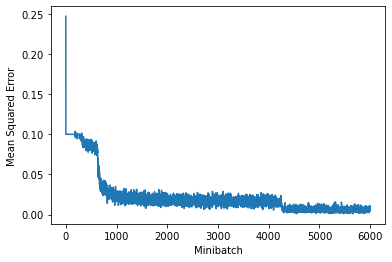

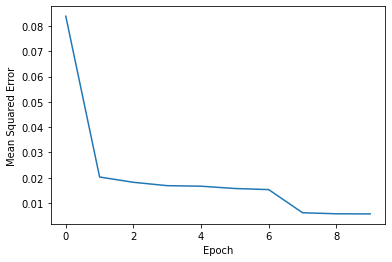

In [8]:
plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.ylabel('Mean Squared Error')
plt.xlabel('Minibatch')
plt.show()

plt.plot(range(len(epoch_cost)), epoch_cost)
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.show()

In [9]:
def compute_accuracy(net, data_loader):
    correct_pred, num_examples = 0, 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.view(-1, 28*28)
            _, outputs = net.forward(features)
            predicted_labels = torch.argmax(outputs, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
        return correct_pred.float()/num_examples * 100

print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Training Accuracy: 96.89
Test Accuracy: 95.81


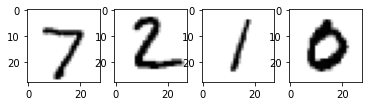

In [10]:
import matplotlib
import matplotlib.pyplot as plt

for features, targets in test_loader:
    break
    
fig, ax = plt.subplots(1, 4)
for i in range(4):
    ax[i].imshow(features[i].view(28, 28), cmap=matplotlib.cm.binary)

plt.show()

In [11]:
_, predictions = model.forward(features[:4].view(-1, 28*28))
predictions = torch.argmax(predictions, dim=1)
print('Predicted labels', predictions)

Predicted labels tensor([7, 2, 1, 0])
